In [1]:
import gc
import pandas as pd
import scipy.sparse as sps

In [2]:
valid=sps.load_npz("./dressipi_dataset/URM_valid_bought.npz")
bought=valid.indices

In [3]:
dataset=None
dataset_max=None
#["UCF","ICBF","ICF","Graph","TopPop100","TopPop50","TopPop15"]
for file in ["UCF","ICBF","Graph","ICF", "TopPop15"]:
    print(gc.collect())
    print(f"loading {file}")
    df=pd.read_csv(f"./dressipi_top100_candidates/{file}.csv")
    print(len(df))
    print(f"loaded {file}")
    for col in df:
        if "Max" in col:
            df_max=df[["Session_Id",col]].drop_duplicates()
        elif "Score" in col:
            df_feats=df[["Session_Id","Item_ID",col]]
    if dataset is None:
        dataset=df_feats
        dataset_max=df_max
    else:
        dataset=dataset.merge(df_feats,on=["Session_Id","Item_ID"],how="outer")
        dataset_max=dataset_max.merge(df_max,on=["Session_Id"],how="outer")
    del df
        

#del dataset_max
del df_feats
del df_max

0
loading UCF
18588455
loaded UCF
0
loading ICBF
16931962
loaded ICBF
0
loading Graph
9381483
loaded Graph
0
loading ICF
20341641
loaded ICF
0
loading TopPop15
8161800
loaded TopPop15


In [4]:
import ast
submission_df=pd.read_csv("./candidate-nn/last_month_candidates.csv")

In [5]:
submission_df["score"]=submission_df["score"].map(ast.literal_eval)
submission_df["code"]=submission_df["code"].map(ast.literal_eval)
submission_df["rank"]=submission_df["rank"].map(ast.literal_eval)

In [6]:
submission_df = submission_df.explode(['code','score', 'rank'])


In [7]:
submission_df[["session_id","code","rank"]]=submission_df[["session_id","code","rank"]].astype(int)

In [8]:
submission_df.rename(columns={"code":"Item_ID","session_id":"Session_Id"},inplace=True)

In [9]:
submission_df.head()

,Session_Id,Item_ID,score,rank
0,918382,3731,0.022378,1
0,918382,2332,0.017789,2
0,918382,2785,0.012271,3
0,918382,1189,0.011465,4
0,918382,4380,0.010622,5


In [10]:
dataset=dataset.merge(submission_df,on=["Session_Id","Item_ID"],how="outer")
dataset=dataset.merge(dataset_max,on=["Session_Id"],how="left")


In [11]:
del dataset_max
del submission_df

In [12]:
import numpy as np
sessions=np.unique(dataset["Session_Id"])
train=pd.DataFrame()
train["Session_Id"]=sessions
train["Item_ID"]=bought
train["target"]=1

In [13]:
gc.collect()

1001

In [14]:
dataset=dataset.merge(train,on=["Session_Id","Item_ID"],how="left")
dataset.fillna(0,inplace=True)
gc.collect()

0

In [15]:
#dataset.loc[dataset["rank"]==0,"rank"]=101
dataset["rank"]=dataset["rank"].astype("int16")
dataset["target"]=dataset["target"].astype("int8")
gc.collect()

0

In [16]:
dataset

,Session_Id,Item_ID,Score_UCF,Score_ICBF,Score_Graph,Score_ICF,Score_TopPop15,score,rank,Max_Score_UCF,Max_Score_ICBF,Max_Score_Graph,Max_Score_ICF,Max_Score_TopPop15,target
0,918382,78,0.515642,0.000000,0.377850,0.587459,0.000000,0.001514,42,60.744503,3.067216,1.982604,0.395666,3599.0,0
1,918382,178,0.281229,0.000000,0.142546,0.412063,0.145596,0.000000,0,60.744503,3.067216,1.982604,0.395666,3599.0,0
2,918382,230,0.127506,0.000000,0.055109,0.022295,0.000000,0.000000,0,60.744503,3.067216,1.982604,0.395666,3599.0,0
3,918382,242,0.395681,0.775898,0.273503,0.514097,0.175604,0.002653,26,60.744503,3.067216,1.982604,0.395666,3599.0,0
4,918382,292,0.200113,0.601746,0.105606,0.458708,0.132815,0.000000,0,60.744503,3.067216,1.982604,0.395666,3599.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43227290,999999,2587,0.000000,0.000000,0.000000,0.000000,0.000000,0.000427,90,111.366875,9.421845,12.826448,0.786831,3599.0,0
43227291,999999,302,0.000000,0.000000,0.000000,0.000000,0.000000,0.000415,94,111.366875,9.421845,12.826448,0.786831,3599.0,0
43227292,999999,434,0.000000,0.000000,0.000000,0.000000,0.000000,0.000411,95,111.366875,9.421845,12.826448,0.786831,3599.0,0
43227293,999999,3077,0.000000,0.000000,0.000000,0.000000,0.000000,0.000407,96,111.366875,9.421845,12.826448,0.786831,3599.0,0


In [17]:
sessions_containing_bought_among_candidates=dataset[["Session_Id","target"]].groupby("Session_Id").agg(sum).reset_index()
sessions_containing_bought_among_candidates=sessions_containing_bought_among_candidates.loc[sessions_containing_bought_among_candidates["target"]>0]

dataset=dataset[dataset['Session_Id'].isin(sessions_containing_bought_among_candidates["Session_Id"].tolist())]

In [18]:
dataset.head(20)

,Session_Id,Item_ID,Score_UCF,Score_ICBF,Score_Graph,Score_ICF,Score_TopPop15,score,rank,Max_Score_UCF,Max_Score_ICBF,Max_Score_Graph,Max_Score_ICF,Max_Score_TopPop15,target
209,918383,55,0.054177,0.632362,0.005355,0.018442,0.000000,0.000000,0,594.02826,7.204127,91.79825,1.092114,3599.0,0
210,918383,122,0.025767,0.000000,0.000000,0.000000,0.000000,0.000390,90,594.02826,7.204127,91.79825,1.092114,3599.0,0
211,918383,189,0.129413,0.000000,0.020602,0.278846,0.334537,0.001349,28,594.02826,7.204127,91.79825,1.092114,3599.0,0
212,918383,215,0.036236,0.000000,0.000000,0.000000,0.126980,0.000000,0,594.02826,7.204127,91.79825,1.092114,3599.0,0
213,918383,260,0.039900,0.000000,0.003595,0.012055,0.000000,0.000000,0,594.02826,7.204127,91.79825,1.092114,3599.0,0
214,918383,320,0.040230,0.000000,0.000000,0.000000,0.150597,0.001628,22,594.02826,7.204127,91.79825,1.092114,3599.0,0
215,918383,357,0.040280,0.000000,0.003286,0.012149,0.000000,0.000000,0,594.02826,7.204127,91.79825,1.092114,3599.0,0
216,918383,379,0.046153,0.637329,0.004070,0.016121,0.000000,0.000387,92,594.02826,7.204127,91.79825,1.092114,3599.0,0
217,918383,421,0.064009,0.604249,0.013832,0.319644,0.000000,0.000000,0,594.02826,7.204127,91.79825,1.092114,3599.0,0
218,918383,506,0.032975,0.493767,0.003990,0.017444,0.000000,0.000000,0,594.02826,7.204127,91.79825,1.092114,3599.0,0


In [19]:
# dataset_macro_features = pd.read_csv('./macro-feats/train_with_macro_feats.csv',
#                                      usecols=['session_id',
#                                                 'session_similarity',
#                                                 'session_similarity_uniques', 'session_similarity_feats', 'session_similarity_feats_uniques',
#                                               'length_of_session_seconds',
#                    'avg_time_spent_per_item_seconds',
#                    'variance_time_spent_per_item_seconds',
#                    'n_seen_items',
#                    'n_unique_items',])
#
# dataset_macro_features.rename(columns={'session_id':'Session_Id'}, inplace=True)

In [20]:
# dataset = dataset.merge(dataset_macro_features, on='Session_Id', how='left')

In [21]:
dataset.drop('Max_Score_TopPop15', axis=1, inplace=True)

/var/folders/j4/lrzvgqtj3bz3ynm2xlxsxtc00000gn/T/ipykernel_18861/3542618527.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.drop('Max_Score_TopPop15', axis=1, inplace=True)


In [22]:
from sklearn.model_selection import train_test_split
train,valid=train_test_split(train,test_size=0.2, random_state=1234)
gc.collect()


0

In [23]:
train_sessions=train["Session_Id"].tolist()
valid_sessions=valid["Session_Id"].tolist()

In [24]:
train=dataset[dataset["Session_Id"].isin(train_sessions)]
gc.collect()
valid=dataset[dataset["Session_Id"].isin(valid_sessions)]
gc.collect()

0

In [25]:
train=train.sort_values("Session_Id")
gc.collect()
valid=valid.sort_values("Session_Id")
gc.collect()

0

In [26]:
qids_train = train[["Session_Id"]].groupby("Session_Id")["Session_Id"].count().to_numpy()
print(len(qids_train)/0.8)
gc.collect()
qids_valid = valid[["Session_Id"]].groupby("Session_Id")["Session_Id"].count().to_numpy()
gc.collect()

61160.0


0

In [27]:
X_train=train.drop(["target","Session_Id","Item_ID"],axis=1)
gc.collect()
y_train=train["target"]
gc.collect()
X_valid=valid.drop(["target","Session_Id","Item_ID"],axis=1)
gc.collect()
y_valid=valid["target"]

In [28]:
gc.collect()

0

In [29]:
import lightgbm

In [30]:
model = lightgbm.LGBMRanker(
    objective="lambdarank",
    #objective="rank_xendcg",
    #metric="mrr",
    n_estimators=2000,
    lambdarank_truncation_level=103,
    reg_alpha=1e-4,
    learning_rate=0.05,
    min_child_samples=600,
    subsample=0.6,
    subsample_freq=10
    
)

In [31]:
ranker=model.fit(
    X=X_train,
    y=y_train,
    group=qids_train,
    eval_set=[(X_valid, y_valid)],
    eval_group=[qids_valid],
    eval_at=(100),
    callbacks=[lightgbm.log_evaluation(),lightgbm.early_stopping(50,first_metric_only=True)],
    #verbose=10,
    eval_metric=["map","ndcg"]
)


[1]	valid_0's map@100: 0.185497	valid_0's ndcg@100: 0.29819
Training until validation scores don't improve for 50 rounds
[2]	valid_0's map@100: 0.228473	valid_0's ndcg@100: 0.333066
[3]	valid_0's map@100: 0.232581	valid_0's ndcg@100: 0.33708
[4]	valid_0's map@100: 0.23534	valid_0's ndcg@100: 0.33968
[5]	valid_0's map@100: 0.237105	valid_0's ndcg@100: 0.341298
[6]	valid_0's map@100: 0.237378	valid_0's ndcg@100: 0.341431
[7]	valid_0's map@100: 0.237826	valid_0's ndcg@100: 0.342017
[8]	valid_0's map@100: 0.23763	valid_0's ndcg@100: 0.341994
[9]	valid_0's map@100: 0.237516	valid_0's ndcg@100: 0.341783
[10]	valid_0's map@100: 0.237378	valid_0's ndcg@100: 0.341739
[11]	valid_0's map@100: 0.238738	valid_0's ndcg@100: 0.342822
[12]	valid_0's map@100: 0.238989	valid_0's ndcg@100: 0.343132
[13]	valid_0's map@100: 0.238867	valid_0's ndcg@100: 0.342982
[14]	valid_0's map@100: 0.23905	valid_0's ndcg@100: 0.343057
[15]	valid_0's map@100: 0.239275	valid_0's ndcg@100: 0.343232
[16]	valid_0's map@100: 

In [32]:
print(len(qids_train))

48928


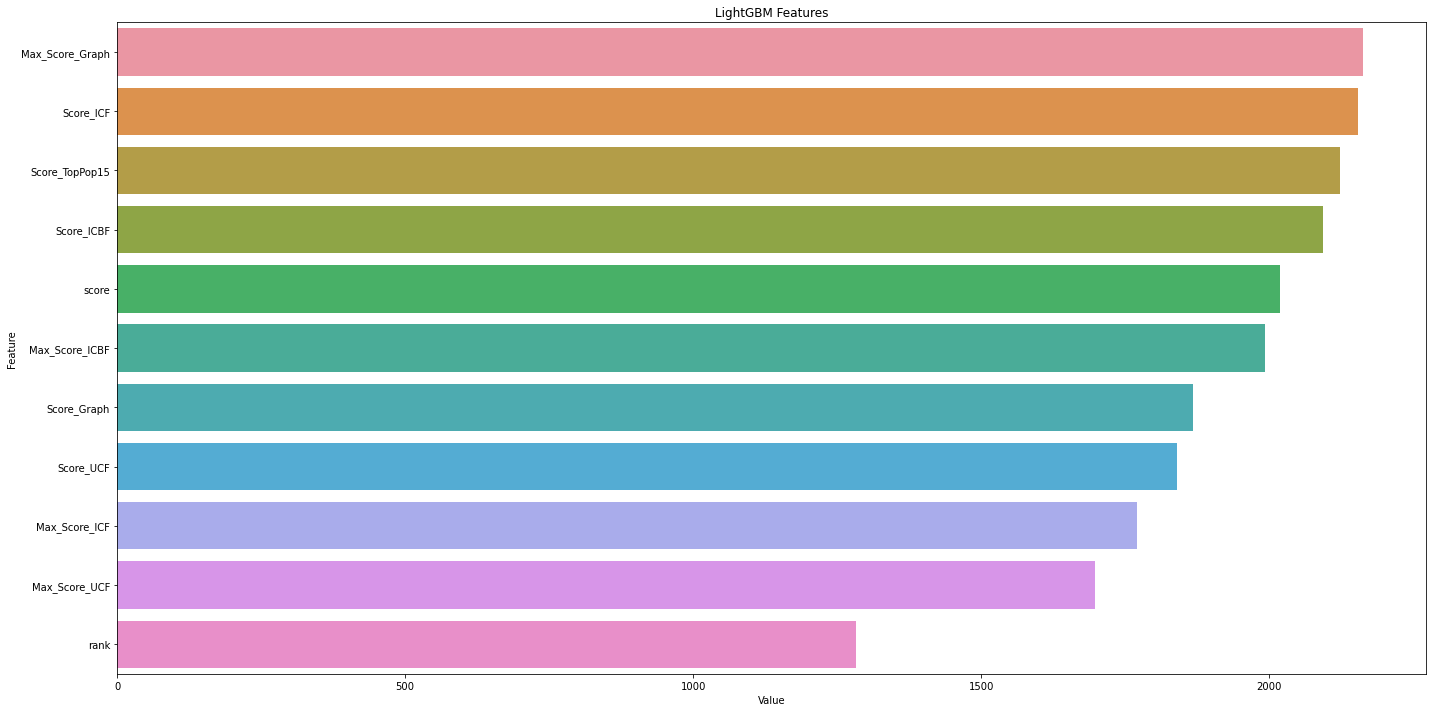

<Figure size 432x288 with 0 Axes>

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(ranker.feature_importances_,X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

In [34]:
ranker.booster_.save_model('mode.txt')